In [1]:
import numpy as np
rd_st = np.random.RandomState(42)
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import networkx as nx
import osmnx as ox
import shapely
import warnings
warnings.filterwarnings('ignore')

import multiprocessing
from multiprocessing import Pool

import time
import ipdb
from IPython import display

%matplotlib inline

In [2]:
from rider import *

# Load data, road network

In [3]:
rand_merchant = np.random.choice(nodes['NodeName'], 20)
rand_merchant

array([ 4722709421,  7053400906, 10864331865,  1363236276,  4682815208,
        5014445785,  4985026476,  6063371030,  1387646749,  1357108491,
         366226936,  3053861879,   244131955,  5250567370,  1841194517,
        1832436606,  3838321209,  5228844715,  4749270945,  3867177047],
      dtype=int64)

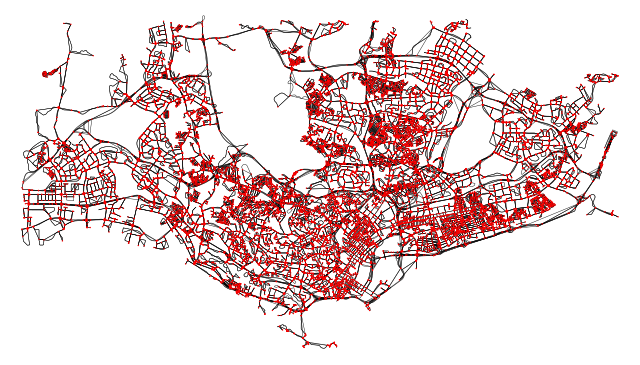

In [4]:
fig, ax = ox.plot.plot_graph(
    G_sgp, node_size=1, node_color='r', bgcolor='w', edge_color='k',
    edge_linewidth=.3, save=0, show=False, close=False
)

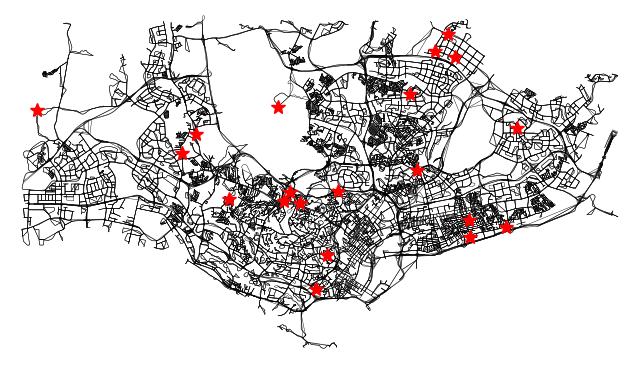

In [5]:
fig, ax = ox.plot.plot_graph(
    G_sgp, node_size=0, bgcolor='w', edge_color='k',
    edge_linewidth=.3, save=0, show=False, close=False
)

for i in rand_merchant:
    ax.plot(
        nodes.loc[nodes['NodeName']==i, 'x'].values[0],
        nodes.loc[nodes['NodeName']==i, 'y'].values[0],
        'r*', markersize=10)


In [4]:
# defined in rider.py
nodes.head()

,NodeName,x,y
0,25451915,103.978767,1.334762
1,25451918,103.973936,1.327573
2,25451929,103.872544,1.295232
3,25455287,103.874004,1.295445
4,25455292,103.908497,1.301013


In [5]:
# defined in rider.py
edges.head()

,EdgeName,from,to,distance,osmid,maxspeed,travel_time_minimum
0,0,25451915,25451918,0.963113,"[166741187, 649636776, 649636777, 717446235, 2...",90,0.010701
1,1,25451918,242636478,0.278409,22617511,50,0.005568
2,2,25451918,1143899970,0.670252,166741192,90,0.007447
3,3,25451929,6749812859,0.765032,"[49961799, 718881456, 741164883, 754786742, 17...",70,0.010929
4,4,25455287,1637003462,0.629055,150829205,50,0.012581


Try Dijkstra method

# Define rider

In [6]:
# in rider.py

# Define platform


In [7]:
class platform:
    def __init__(self, r, cR, k, t):
        self.customer_df = pd.DataFrame(
            [],
            columns=[
                'node_ID',
                'merchant_node',
                'waiting_time',
                'position_x',
                'position_y'
            ]
        )

        self.matched_customer_df = pd.DataFrame(
            [],
            columns=[
                'node_ID',
                'merchant_node',
                'waiting_time',
                'position_x',
                'position_y'
            ]
        )
        
        self.num_accumulated_order = 0
        self.r = r
        self.cR = cR
        self.k = k
        self.t = t
    
    def update_cust_df_with_new_rand_num_cust(self, n=1):
        c = 0
        while True and n > 0:
            ind = self.customer_df.shape[0]
            node_ID = rd_st.choice(list(nodes['NodeName']))
            node_position = get_node_xy(node_ID)
            merchant_node = rd_st.choice(merchant_node_set)
            
            if np.linalg.norm(node_position - get_node_xy(merchant_node)) * 111 < cR:
                new_customer = pd.DataFrame(
                    [[node_ID, merchant_node, 0, node_position[0], node_position[1]]],
                    index=[ind],
                    columns=['node_ID', 'merchant_node', 'waiting_time', 'position_x', 'position_y']
                )
                self.customer_df = pd.concat([self.customer_df, new_customer], axis=0, ignore_index=True)
                c = c + 1
                
            if c == n:
                break
    
    def acquire_order(self, q):
        # num_generated_order_c is continuous ('_c'), not discrete
        num_generated_order_c = rd_st.rand() * q * t_resolution * 2
        self.num_accumulated_order += num_generated_order_c
        num_generated_order = int(self.num_accumulated_order - self.customer_df.shape[0])
        
        self.update_cust_df_with_new_rand_num_cust(num_generated_order)
        
        self.customer_df['waiting_time'] = self.customer_df['waiting_time'] + t_resolution
        self.matched_customer_df['waiting_time'] = self.matched_customer_df['waiting_time'] + t_resolution

    def update_matched_order(self, matched_batches):
        for i in matched_batches.flatten():
            first_cust_ind = self.customer_df.loc[self.customer_df['node_ID']==i, 'waiting_time'].astype(float).idxmax()
            self.matched_customer_df = self.matched_customer_df.append(self.customer_df.loc[first_cust_ind])
            self.customer_df = self.customer_df.drop(index=first_cust_ind)
        
        self.matched_customer_df.index = range(self.matched_customer_df.shape[0])
        self.customer_df.index = range(self.customer_df.shape[0])
        
        self.num_accumulated_order -= matched_batches.size
    
    def match(self, idle_rider_IDs, rider_set):
        # when multiprocessing, the rider ID and index of each rider
        # in the rider_set list are not necessarily the same
        rider_ID_set = [i.ID for i in rider_set]
        rider_index_df = pd.DataFrame(range(len(rider_ID_set)), index=rider_ID_set, columns=['ind'])
        
        matched_batches = []
        matched_rider_IDs = []
        matched_merchants = []
        
        for i in range(len(merchant_node_set)):
            # first find corresponding idle rider IDs
            merchant_node = merchant_node_set[i]
            idle_rider_IDs_this_merchant = []
            for idle_rider_ID in idle_rider_IDs:
                idle_rider = rider_set[rider_index_df.loc[idle_rider_ID, 'ind']]
                if idle_rider.closest_merchant_node==merchant_node:
                    idle_rider_IDs_this_merchant.append(idle_rider_ID)
            n_idle_riders_this_merchant = len(idle_rider_IDs_this_merchant)
            
            # accumulatd orders for this merchant
            acc_ord_this_mer_df = self.customer_df.loc[self.customer_df['merchant_node']==merchant_node]
            acc_ord_this_mer = acc_ord_this_mer_df['node_ID'].astype(np.int64).values
            
            num_required_riders_this_merchant = min(
                n_idle_riders_this_merchant,
                # number of accumulated orders for this merchant // k
                len(acc_ord_this_mer) // self.k
            )
            
            matched_rider_IDs_this_merchant = list(rd_st.choice(
                idle_rider_IDs_this_merchant,
                num_required_riders_this_merchant,
                replace=False
            ))

            matched_batches_this_merchant = []
            for j in range(len(matched_rider_IDs_this_merchant)):
                matched_batches_this_merchant.append(acc_ord_this_mer[self.k*j:self.k*(j+1)])
                matched_merchants.append(merchant_node)
            matched_batches_this_merchant = np.array(matched_batches_this_merchant)
            
            matched_batches.extend(matched_batches_this_merchant)
            matched_rider_IDs.extend(matched_rider_IDs_this_merchant)

        matched_batches = np.array(matched_batches)
        # remove the matched orders
        self.update_matched_order(matched_batches)
        W_cq_4_matched_customers = []
        for i in np.array(matched_batches).flatten():
            W_cq_4_matched_customers.append(self.customer_df['waiting_time'])
        avg_W_cq = np.mean(W_cq_4_matched_customers) if len(W_cq_4_matched_customers)>0 else np.nan
        
        # their indexes are mutually matched
        return matched_batches, matched_rider_IDs, matched_merchants, avg_W_cq  
        

In [8]:
# Multi processing, but it is slower if the step length is small, say, one
def move_all_riders():
    # number of riders at each process
    N_each_process = N // (n_cpu - 1) if N%n_cpu != 0 else N // n_cpu
    n_process = N//N_each_process+1 if N%N_each_process != 0 else N//N_each_process

    params = []
    for i in range(n_process):
        params.append(
            [
                rider_set[i*N_each_process:(i+1)*N_each_process],
                t_resolution,
                matched_rider_IDs,
                matched_batches,
                matched_merchants,
                dec_var
            ]
        )
    
    moved_rider_set = pool.starmap(func=move_rider, iterable=params )
    return moved_rider_set


In [9]:
config_set = []
rider_set = []
N = 300
q_bar = 300
r = 2
cR = 4
k = 3
t = 0.005

Delta = cR
t_resolution = 0.01
match_period = t//t_resolution if t%t_resolution==0 else t//t_resolution+1

dec_var = {
    'r': r,
    'cR': cR,
    'k': k,
    't': t,
    'N': N,
    'q_bar': q_bar
}

merchant_node_set = rand_merchant

In [10]:
# born of riders
num_new_riders = N


num_exist_riders = len(rider_set)
new_rider_count = 0
while new_rider_count < num_new_riders:
    config_i = {
        'ID': num_exist_riders + new_rider_count,
        'initial_position': np.array(
            [rd_st.rand() * (nodes['x'].max() - nodes['x'].min()) + nodes['x'].min(),
             rd_st.rand() * (nodes['y'].max() - nodes['y'].min()) + nodes['y'].min()]
        ),
        'maxspeed': rd_st.randint(10, 20) / 111  # transfer from km to lon-lat
    }
    rider_i = rider(config_i, dec_var, merchant_node_set, rd_st)
    
    config_set.append(config_i)
    rider_set.append(rider_i)
    
    new_rider_count += 1

In [11]:
virtual_plat = platform(r, cR, k, t)

In [12]:
c = 0
x_axis = []
num_idle_rider_IDs_set = []
num_accumulated_batch_set = []
p_set = []
pp_set = []
avg_W_cq_set = []

In [13]:
n_cpu = multiprocessing.cpu_count()
pool = Pool(processes=n_cpu)

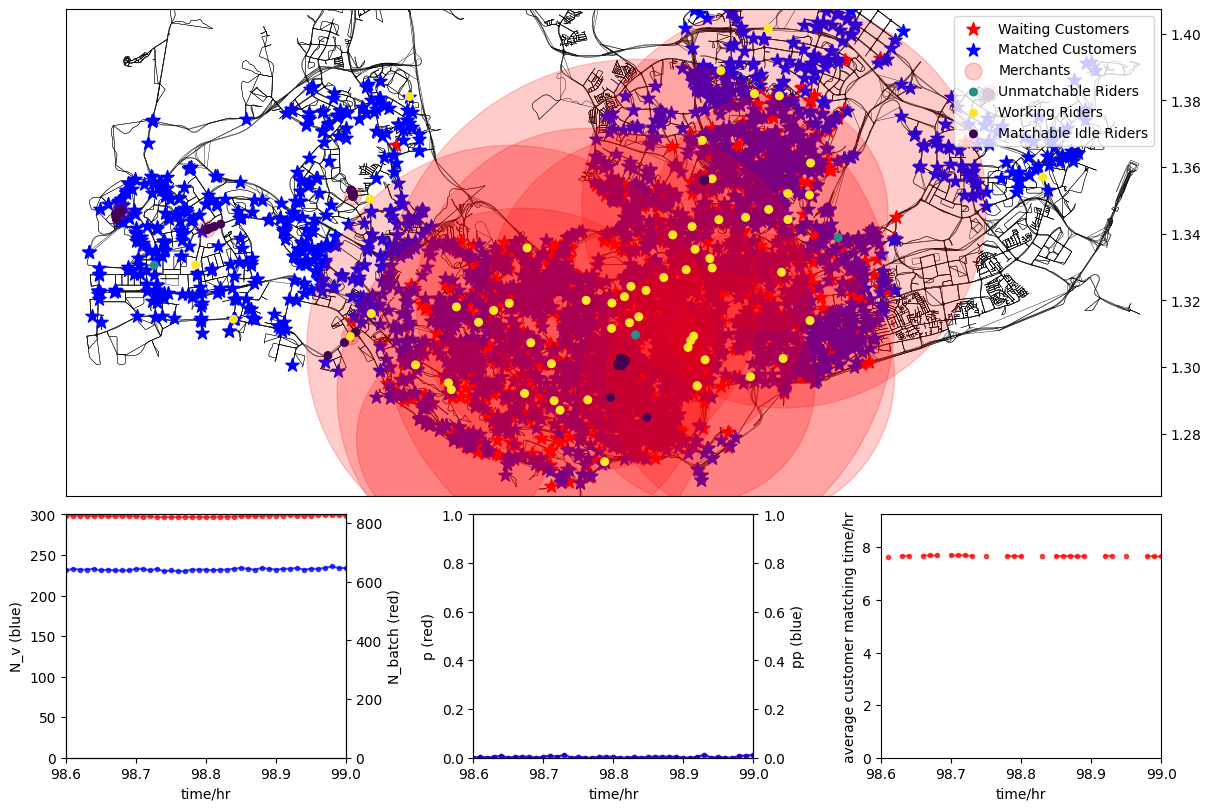

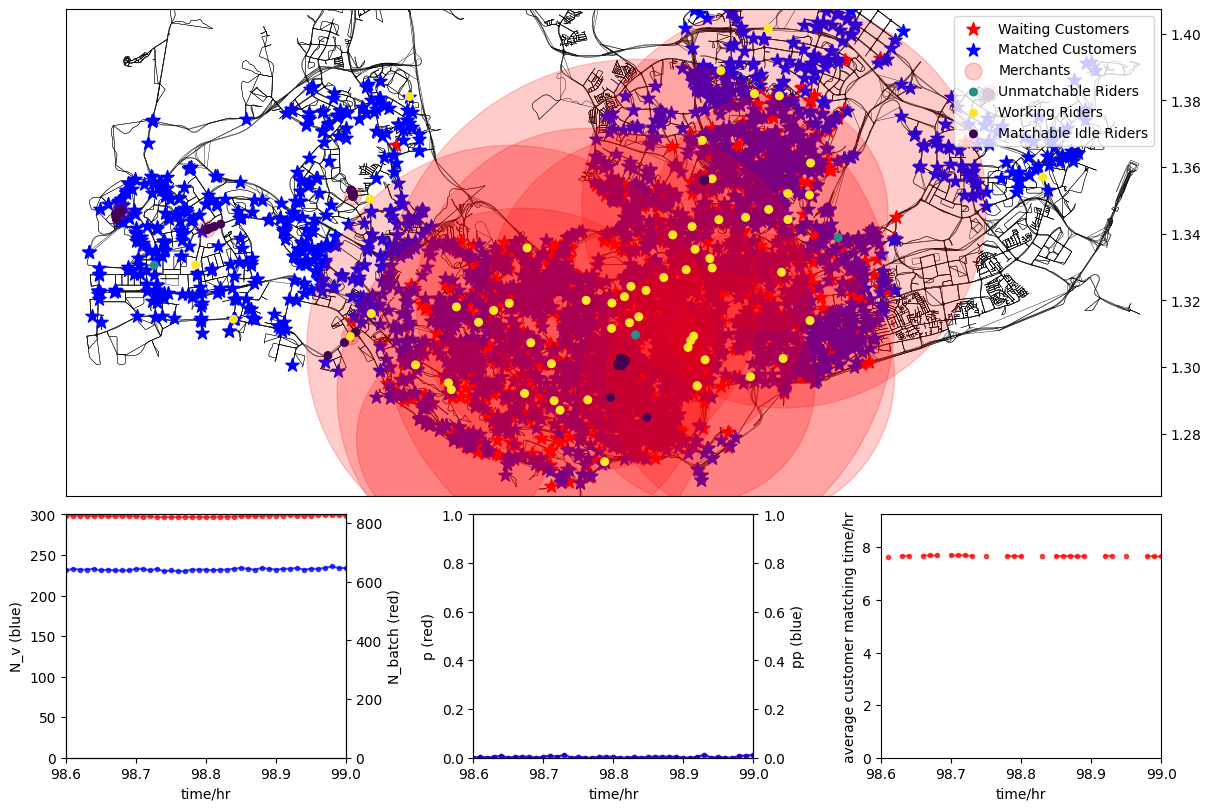

In [14]:
# # marking the x-axis and y-axis
fig = plt.figure(constrained_layout=True, figsize=[12, 8])
gs = fig.add_gridspec(3, 3)
ax0 = fig.add_subplot(gs[:2, :3])
ox.plot.plot_graph(
    G_sgp, ax=ax0, node_size=0, bgcolor='w', edge_color='k',
    edge_linewidth=.3, save=0, show=False, close=False
)
# nx.draw_networkx(G_sgp, pos=pos, ax=ax0, node_size=15, node_color='gray', with_labels=False)
ax = ax0.twinx()
ax.set_xlim(ax0.get_xlim())
ax.set_ylim(ax0.get_ylim())
ax.set_aspect((north - south)*aspect_ratio / (east - west))

ax2 = fig.add_subplot(gs[2, 0])
ax2.set_ylabel('N_v (blue)')
ax2.set_xlabel('time/hr')
ax3 = ax2.twinx()
ax3.set_ylabel('N_batch (red)')
ax3.set_xlabel('time/hr')
ax4 = fig.add_subplot(gs[2, 1])
ax4.set_ylabel('p (red)')
ax4.set_xlabel('time/hr')
ax4.set_ylim([0, 1])
ax5 = ax4.twinx()
ax5.set_ylabel('pp (blue)')
ax5.set_xlabel('time/hr')
ax5.set_ylim([0, 1])
ax6 = fig.add_subplot(gs[2, 2])
ax6.set_ylabel('average customer matching time/hr')
ax6.set_xlabel('time/hr')

# plt.tight_layout()


scat2 = ax.scatter([], [], color='red', marker='*', s=100, label='Waiting Customers')  # for waiting customers
scat3 = ax.scatter([], [], color='blue', marker='*', s=100, label='Matched Customers')  # for matched customers
scat4 = ax.scatter([], [], color='red', alpha=0.2, label='Merchants', s=150)  # for merchants

# riders
color = np.ones(N) * 0.5
scat = ax.scatter(-10*np.ones(len(rider_set)), -10*np.ones(len(rider_set)), s=30, c=np.ones(N) * 0.5, vmin=0, vmax=1, label='Unmatchable Riders')
ax.scatter(-10*np.ones(len(rider_set)), -10*np.ones(len(rider_set)), s=30, c=np.ones(N), vmin=0, vmax=1, label='Working Riders')
ax.scatter(-10*np.ones(len(rider_set)), -10*np.ones(len(rider_set)), s=30, c=np.zeros(N), vmin=0, vmax=1, label='Matchable Idle Riders')
ax.legend(loc='upper right')

line2, = ax2.plot([], [], 'b.-', alpha=0.7)
line3, = ax3.plot([], [], 'r.-', alpha=0.7)
line4, = ax4.plot([], [], 'r.-', alpha=0.7)
line5, = ax5.plot([], [], 'b.-', alpha=0.7)
line6, = ax6.plot([], [], 'r.-', alpha=0.7)

while c <= 9900:
    idle_rider_IDs = []
    for i in range(N):
        if rider_set[i].state=='idle' and rider_set[i].if_matchable:
            idle_rider_IDs.append(rider_set[i].ID)

    q = q_bar * cR**2 / Delta**2
    virtual_plat.acquire_order(q)

    if int(c%match_period)==0:
        matched_batches, matched_rider_IDs, matched_merchants, avg_W_cq = virtual_plat.match(
            idle_rider_IDs, rider_set
        )
    else:
        matched_batches, matched_rider_IDs, matched_merchants, avg_W_cq = np.array([]), [], [], np.nan

    num_matched_cust = matched_batches.size if int(c%match_period)==0 else np.nan
    try:
        p = num_matched_cust / (num_matched_cust + virtual_plat.num_accumulated_order/k)
    except:
        # when there is no order
        p = np.nan
    num_matched_rider_IDs = num_matched_cust // k
    try:
        pp = num_matched_rider_IDs / len(idle_rider_IDs)
    except:
        pp = np.nan

    # move use single processor
#     rider_set = move_rider(
#         rider_set, t_resolution, matched_rider_IDs, matched_batches, matched_merchants, dec_var
#     )
    # for multiprocessing, uncomment the following lines
    moved_rider_set = move_all_riders()
    moved_rider_set = [item for sublist in moved_rider_set for item in sublist]
    rider_set = moved_rider_set

    # update delivered customers
    delivered_customers_set = []
    for each_rider in rider_set:
        delivered_customers_set.append(each_rider.newly_finished_destination)

    for delivered_customer in delivered_customers_set:
        if delivered_customer in list(virtual_plat.matched_customer_df['node_ID']):
            virtual_plat.matched_customer_df = virtual_plat.matched_customer_df.drop(
                virtual_plat.matched_customer_df.loc[
                    virtual_plat.matched_customer_df['node_ID']==delivered_customer, 'waiting_time'
                ].astype(float).idxmax()
            )
    virtual_plat.matched_customer_df.index = range(virtual_plat.matched_customer_df.shape[0])

    time_now = c * t_resolution
    x_axis.append(time_now)
    num_idle_rider_IDs_set.append(len(idle_rider_IDs))
    num_accumulated_batch_set.append(virtual_plat.num_accumulated_order/k)  # continuous
    p_set.append(p)
    pp_set.append(pp)
    avg_W_cq_set.append(avg_W_cq)

    if c>=500 and c%1==0:
        # plot customers
        if virtual_plat.customer_df.shape[0]>0:
            cust_pos = np.array(virtual_plat.customer_df[['position_x', 'position_y']].to_numpy())
            scat2.set_offsets(cust_pos)
        if virtual_plat.matched_customer_df.shape[0] > 0:
            cust_pos_m = np.array(virtual_plat.matched_customer_df[['position_x', 'position_y']].to_numpy())
            scat3.set_offsets(cust_pos_m)

        # plot riders
        for i in range(N):
            if rider_set[i].state == 'idle' and rider_set[i].if_matchable:
                color[i] = 0
            elif rider_set[i].state == 'working' or rider_set[i].state == 'stop':
                color[i] = 1
            elif rider_set[i].state == 'idle' and rider_set[i].if_matchable==False:
                color[i] = 0.5
        scat.set_array(color)
        scat.set_offsets(
            np.array( [ [rider_set[i].position[0], rider_set[i].position[1]] for i in range(N)] )
        )

        # plot merchants
        merchant_pos = [[get_node_xy(i)[0], get_node_xy(i)[1]] for i in merchant_node_set]
        scat4.set_offsets(np.array(merchant_pos))
        acc_orders_by_merchant = []
        for i in merchant_node_set:
            acc_orders_by_merchant.append(virtual_plat.customer_df.loc[virtual_plat.customer_df['merchant_node']==i].shape[0])
        scat4.set_sizes(150 + np.array(acc_orders_by_merchant)**2)

        line2.set_data(x_axis, num_idle_rider_IDs_set)
        ax2.set_ylim([min(num_idle_rider_IDs_set), N])
        line3.set_data(x_axis, num_accumulated_batch_set)
        ax3.set_ylim([0, max(num_accumulated_batch_set)])
        line4.set_data(x_axis, p_set)
        line5.set_data(x_axis, pp_set)
        line6.set_data(x_axis, avg_W_cq_set)

        ax2.set_xlim([max(0, time_now - 0.4), time_now])
        ax3.set_xlim([max(0, time_now - 0.4), time_now])
        ax4.set_xlim([max(0, time_now - 0.4), time_now])
        ax5.set_xlim([max(0, time_now - 0.4), time_now])
        ax6.set_xlim([max(0, time_now - 0.4), time_now])
        if np.isnan(np.nanmax(avg_W_cq_set))==False:
            ax6.set_ylim([0, 1.2 * np.nanmax(avg_W_cq_set)])

        display.clear_output(wait=True)
        display.display(plt.gcf())

        fig.savefig('./res_img/%i%.4f.png'%(time_now//10, time_now-time_now//10*10 ), dpi=75)
    c += 1


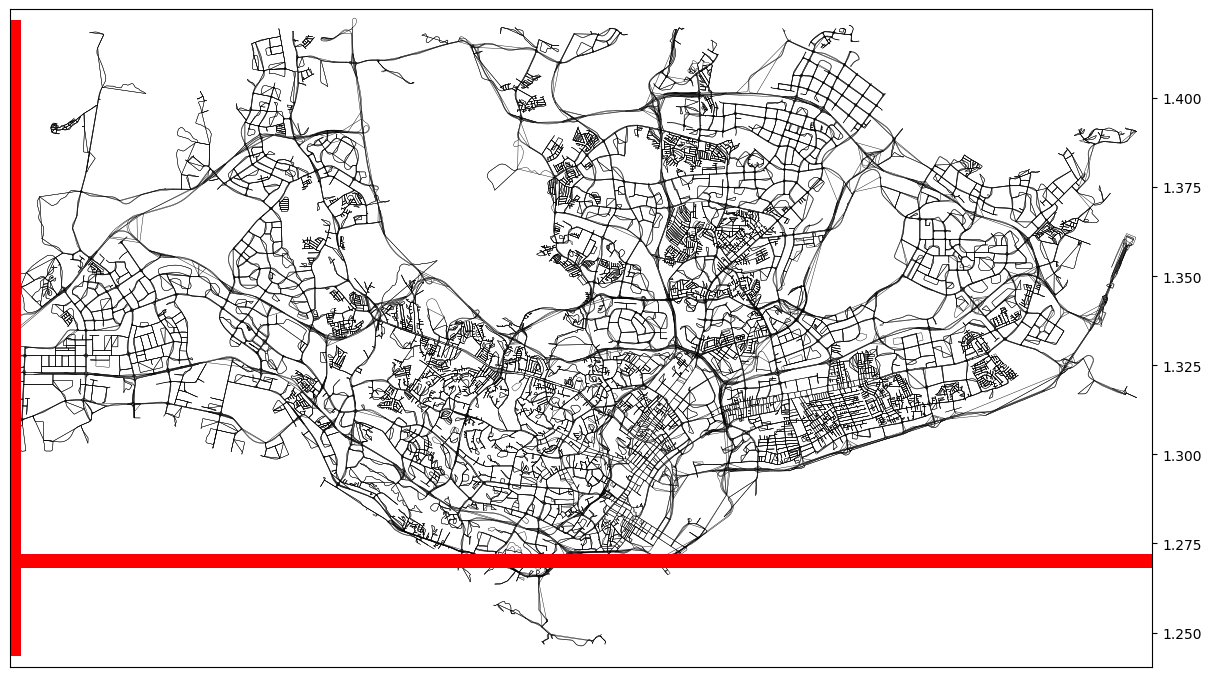

In [21]:
fig = plt.figure(constrained_layout=True, figsize=[12, 10])
gs = fig.add_gridspec(3, 3)
ax0 = fig.add_subplot(gs[:2, :3])

ox.plot.plot_graph(
    G_sgp, ax=ax0, node_size=0, bgcolor='w', edge_color='k',
    edge_linewidth=.3, save=0, show=False, close=False, bbox = (north, south, east, west)
)
ax0.plot([west*1.00001, west*1.00001], [north, south], 'b', lw=10)
ax0.plot([west, east], [south*1.02, south*1.02], 'b', lw=10)

ax = ax0.twinx()
# ax.set_ylim(ax0.get_ylim())
ax.set_aspect((north - south)*1.84 / (east - west))

ax.plot([west*1.00001, west*1.00001], [north, south], 'r', lw=10)
ax.plot([west, east], [south*1.02, south*1.02], 'r', lw=10)

In [17]:
# # make gif
# import glob
# from PIL import Image
# def make_gif(frame_folder):
#     frames = [Image.open(image) for image in sorted(glob.glob(f"{frame_folder}/*.png"))]
#     frame_one = frames[0]
#     frame_one.save('./res_img/demo0.gif', format="GIF", append_images=frames,
#                save_all=True, duration=35, loop=0)
    

# make_gif("./res_img/")

In [1]:
import cv2
import numpy as np
import glob

img_array = []
for filename in sorted(glob.glob("res_img/*.png")):
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)


out = cv2.VideoWriter('./res_img/project_sgp.mp4',cv2.VideoWriter_fourcc('m', 'p', '4', 'v') , 15, size)
 
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()



In [2]:
import os
for i in sorted(glob.glob("res_img/*.png")):
    os.remove(i)